# **Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore")

# **Load the Dataset**

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Understand And Organize the Datase**

In [3]:
# Check data types
print(f"x_train data type: {type(x_train)}")
print(f"y_train data type: {type(y_train)}")
print(f"x_test data type: {type(x_test)}")
print(f"y_test data type: {type(y_test)}\n")

# Check shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

# Check unique values in target variables
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}\n")

# Check if there is any missing data
print(f"Any missing values in x_train: {np.any(np.isnan(x_train))}")
print(f"Any missing values in y_train: {np.any(np.isnan(y_train))}")
print(f"Any missing values in x_test: {np.any(np.isnan(x_test))}")
print(f"Any missing values in y_test: {np.any(np.isnan(y_test))}")

x_train data type: <class 'numpy.ndarray'>
y_train data type: <class 'numpy.ndarray'>
x_test data type: <class 'numpy.ndarray'>
y_test data type: <class 'numpy.ndarray'>

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)

Unique values in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique values in y_test: [0 1 2 3 4 5 6 7 8 9]

Any missing values in x_train: False
Any missing values in y_train: False
Any missing values in x_test: False
Any missing values in y_test: False


In [4]:
num_labels = len(np.unique(y_train))
num_labels

10

# **EDA (Exploratory Data Analysis)**

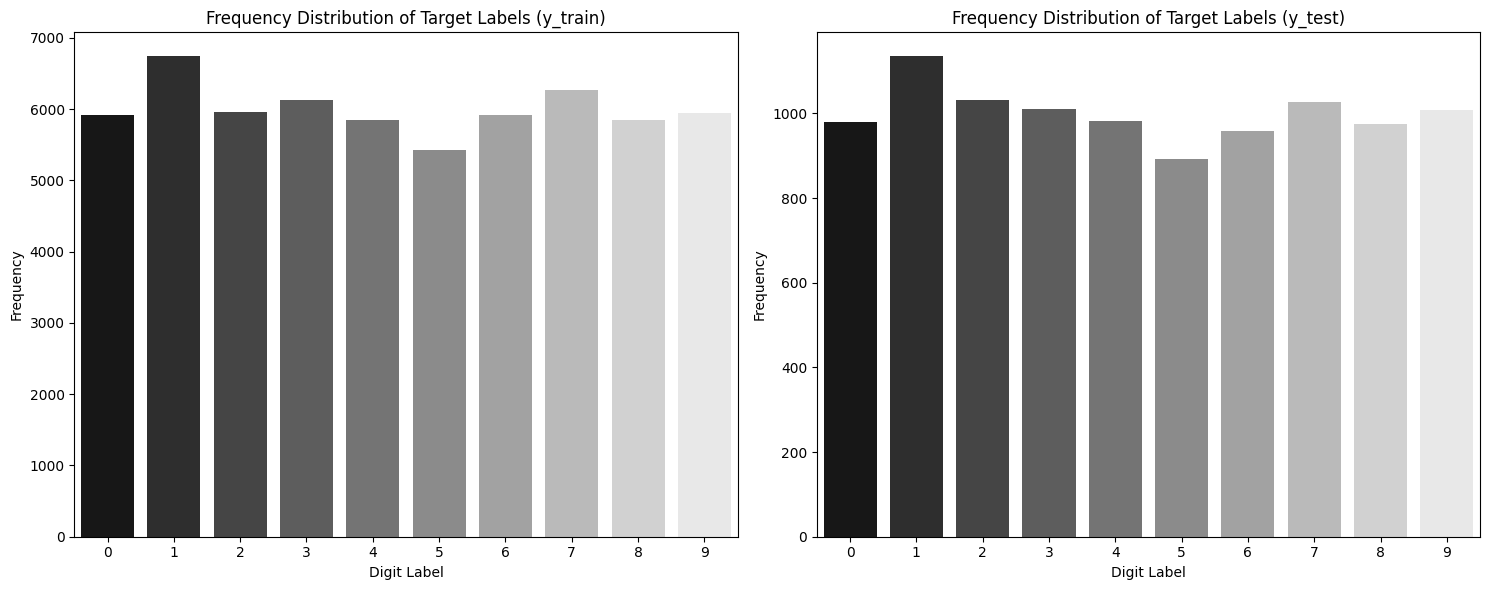

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x=y_train, palette='gray', ax=axes[0])
axes[0].set_title('Frequency Distribution of Target Labels (y_train)')
axes[0].set_xlabel('Digit Label')
axes[0].set_ylabel('Frequency')

sns.countplot(x=y_test, palette='gray', ax=axes[1])
axes[1].set_title('Frequency Distribution of Target Labels (y_test)')
axes[1].set_xlabel('Digit Label')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

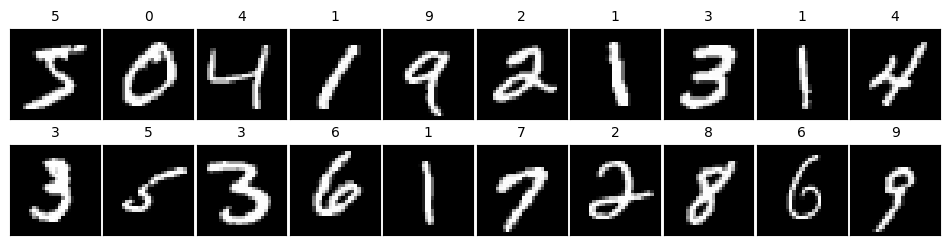

In [6]:
def visualize_images(data):
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12,3),
                             gridspec_kw={'wspace':0.04, 'hspace':0.01}, 
                             squeeze=True)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_train[i], cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_title(str(y_train[i]), fontsize=10)
        
    plt.tight_layout()
    plt.show()

visualize_images(x_train)

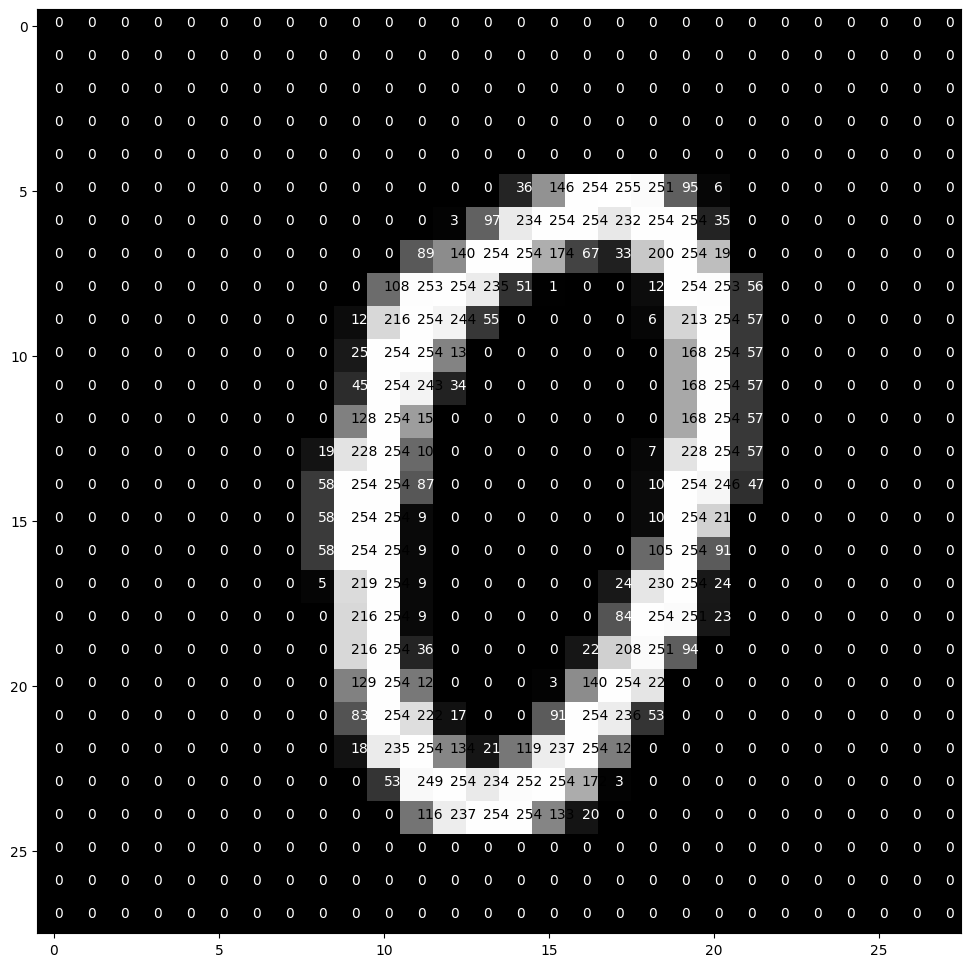

In [7]:
def pixel_visualize(img):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")
    width, height = img.shape
    threshold = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y,x), 
                       color='white' if img [x][y]<threshold else 'black')

pixel_visualize(x_train[1000])

# **Preprocessing**

In [8]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [11]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [12]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# **Model Building**

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 892,266 (3.40 MB)

 Trainable params: 891,050 (3.40 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [16]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=512), epochs=20, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.5642 - loss: 1.5411 - precision: 0.6446 - recall: 0.5033 - val_accuracy: 0.1135 - val_loss: 5.5066 - val_precision: 0.1135 - val_recall: 0.1135
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.8995 - loss: 0.3240 - precision: 0.9209 - recall: 0.8820 - val_accuracy: 0.1135 - val_loss: 6.1550 - val_precision: 0.1135 - val_recall: 0.1135
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9358 - loss: 0.2141 - precision: 0.9482 - recall: 0.9258 - val_accuracy: 0.1164 - val_loss: 3.9529 - val_precision: 0.1161 - val_recall: 0.1143
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.9502 - loss: 0.1656 - precision: 0.9599 - recall: 0.9428 - val_accuracy: 0.5830 - val_loss: 1.3027 - val_precision: 0.5961 - val_recall: 0.5392
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9593 - loss: 0.1310 - precision: 0.9681 - recall: 0.9535 - val_accuracy: 0.9819

# **Results and Visualization of the Model**

In [17]:
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
class_labels = ['0','1','2','3','4','5','6','7','8','9']
report = classification_report(y_true, y_pred_class, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



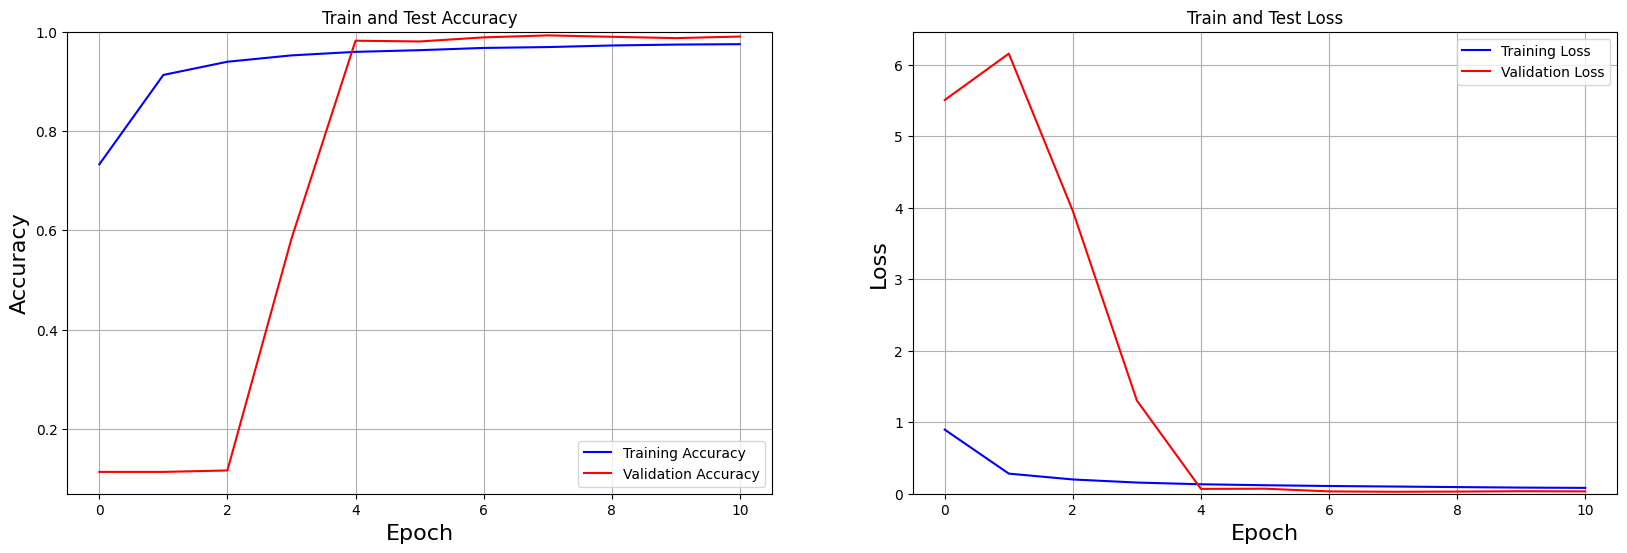

In [19]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Train and Test Accuracy')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Train and Test Loss')
plt.grid(True)
plt.show()

In [20]:
loss, precision, recall, acc=model.evaluate(x_test, y_test, verbose=False)
print('Test Accuracy: ', acc)
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)

Test Accuracy:  0.9926000237464905
Test Loss:  0.027210460975766182
Test Precision:  0.9931952357292175
Test Recall:  0.9925000071525574


In [21]:
model.save('mnist_model.h5')

In [22]:
import random
random = random.randint(0, x_test.shape[0])
random

249

In [23]:
test_image = x_test[random]
y_test[random]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

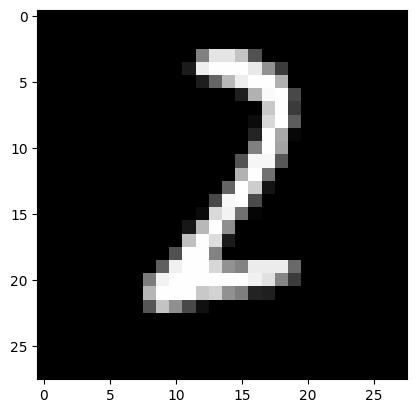

In [24]:
plt.imshow(test_image.reshape(28,28), cmap='gray');

In [25]:
test_data = x_test[random].reshape(1,28,28,1)
probability = model.predict(test_data)
probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


array([[3.8012549e-05, 2.6576472e-03, 9.9079204e-01, 1.7975219e-05,
        9.1969014e-05, 2.4515424e-07, 3.3844949e-06, 6.3857390e-03,
        9.4182815e-06, 3.4879463e-06]], dtype=float32)

In [26]:
predicted_classes = np.argmax(probability)
predicted_classes

2

In [27]:
print(f'Predicted class: {predicted_classes}')
print(f'Predicted class probability value: {(np.argmax(probability, axis=-1))[0]}')
print(f'Probability values of other classes: \n{probability}')

Predicted class: 2
Predicted class probability value: 2
Probability values of other classes: 
[[3.8012549e-05 2.6576472e-03 9.9079204e-01 1.7975219e-05 9.1969014e-05
  2.4515424e-07 3.3844949e-06 6.3857390e-03 9.4182815e-06 3.4879463e-06]]


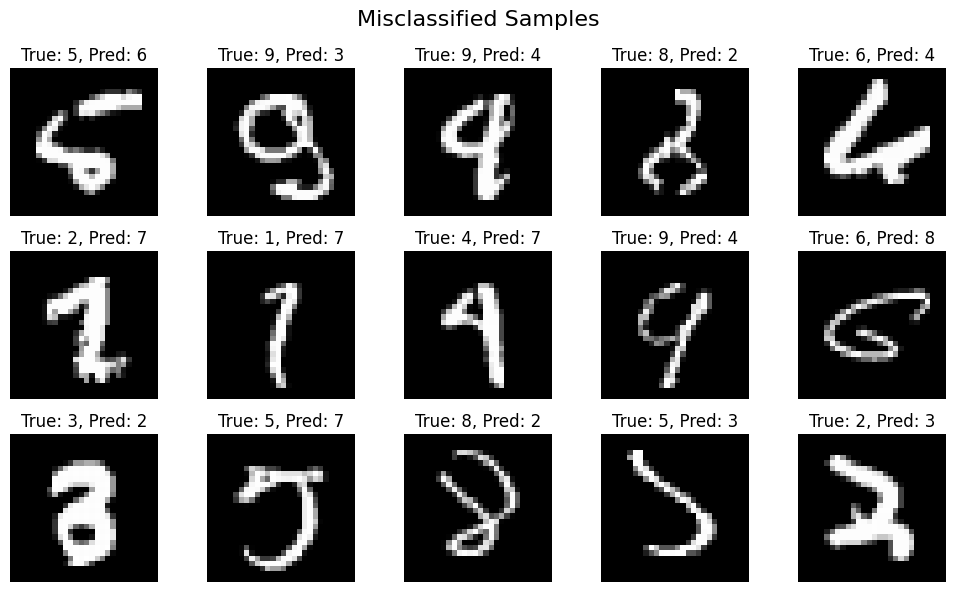

In [28]:
y_test_labels = np.argmax(y_test, axis=1)

misclassified_idx = np.where(y_pred_class != y_test_labels)[0]

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("Misclassified Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = misclassified_idx[i]
    ax.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test_labels[idx]}, Pred: {y_pred_class[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

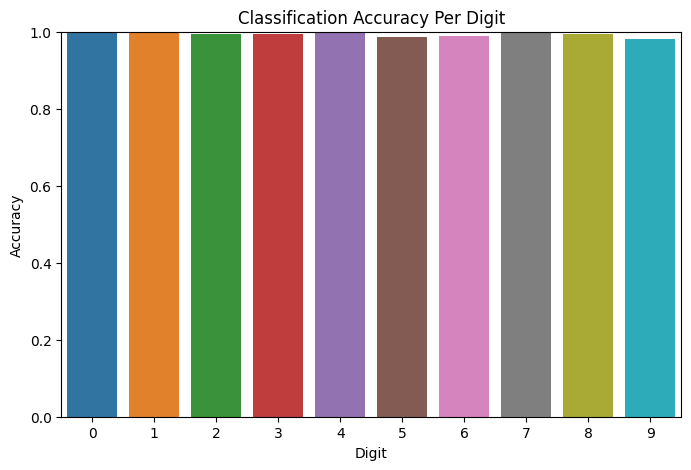

In [29]:
num_classes = 10
class_accuracies = []

for i in range(num_classes):
    correct = np.sum((y_test_labels == i) & (y_pred_class == i))
    total = np.sum(y_test_labels == i)
    accuracy = correct / total if total > 0 else 0
    class_accuracies.append(accuracy)

df = pd.DataFrame({"Digit": range(10), "Accuracy": class_accuracies})

plt.figure(figsize=(8, 5))
sns.barplot(x="Digit", y="Accuracy", data=df)
plt.ylim(0, 1)
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy Per Digit")
plt.show()

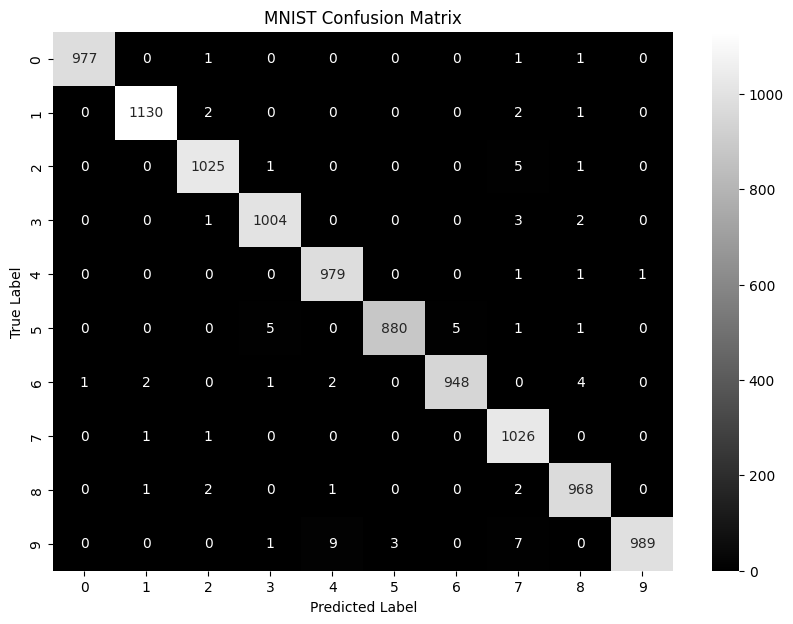

In [30]:
y_pred_labels = y_pred_class
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gray", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()